In [1]:
# load heatsequer and other modules
%matplotlib notebook
import heatsequer as hs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


('loading cooldb',)
('cooldb loaded',)
('loading bactdb',)
('bactdb loaded',)
('loading supercooldb',)
('supercooldb loaded',)


In [2]:
# set display to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [101]:
def teststability(expdat,time0val='1',time1val='2',temp='amb',mincut=5,upres=False,time0temp='amb',timefield='time_numeric',tempfield='temp2',subjectfield='subject',presfield='preservative',printthresh=10):
    """
    calculate foldchange for all bacteria in experiment
    
    input:
    expdat - the experiment
    time0val - value for timepoint 0 (i.e. '1')
    time1val - value for timepoint 1 (i.e. '2' or '4')
    temp - the temperature (i.e. 'amb' or '20C' or 'Heat')
    mincut - the minimal number of reads (out of 10k) to round the number of reads to (to remove effect of discretization on small numbers)
    saveto - dir name to append the result statistics and figures or False to skip
    upres - False to do on all preservatives, otherwise list of unique preservatives (in order)
    time0temp - the temperature for time0 samples (default 'amb')

    output:
    fc : dict of float
        the log2 fold change per otu (keyed by sequence)
    """
    fc={}
    # keep only samples with enough reads
    expdat=hs.filterorigreads(expdat,2500)
    if tempfield=='':
        expdat0=hs.copyexp(expdat)
    else:
        expdat0=hs.filtersamples(expdat,tempfield,time0temp,exact=True)
        expdat=hs.filtersamples(expdat,tempfield,temp,exact=True)

    ids=hs.getfieldvals(expdat,subjectfield)
    uids=list(set(ids))
    pres=hs.getfieldvals(expdat,presfield,ounique=True)
    if len(pres)>1:
        raise RunTimeError('more than 1 preservative!!!')

    allvalsdict={}
    rat=[]
    for cid in expdat.sids:
        rat.append([])

    atime0=hs.filtersamples(expdat0,timefield,time0val)
    atime1=hs.filtersamples(expdat,timefield,time1val)
    allx=[]
    ally=[]
    ccall=[]
    for ididx,cid in enumerate(uids):
        tp1=hs.findsamples(atime1,subjectfield,cid)
        tp0=hs.findsamples(atime0,subjectfield,cid)
        if len(tp1)==0:
            continue
        if len(tp0)==0:
            continue

        if len(tp0)>1:
            time0m=np.mean(atime0.data[:,tp0],1)
        else:
            time0m=atime0.data[:,tp0[0]]
        if len(tp1)>1:
            time1m=np.mean(atime1.data[:,tp1],1)
        else:
            time1m=atime1.data[:,tp1[0]]

        for otuidx,cid in enumerate(atime0.sids):
            if time0m[otuidx]<mincut:
                if time1m[otuidx]<mincut:
                    continue
                else:
                    time0m[otuidx]=mincut
            if time1m[otuidx]<mincut:
                time1m[otuidx]=mincut
            rat[otuidx].append(float(time1m[otuidx])/time0m[otuidx])
    vals=[]
    allvals=[]
    fids=[]
    ftax=[]
    fseqs=[]
    for idx,crat in enumerate(rat):
        if len(crat)>0:
            vals.append(np.log2(np.mean(crat)))
            allvals.append(np.log2(np.mean(crat)))
            fids.append(expdat.sids[idx])
            ftax.append(expdat.tax[idx])
            fseqs.append(expdat.seqs[idx])
        else:
            allvals.append(0)
    print("number of outliers (10 fold) %d" % np.sum(np.abs(vals)>=np.log2(10)))
    print("fraction of outliers (10 fold) %f" % (float(np.sum(np.abs(vals)>=np.log2(10)))/len(vals)))
    print("mean abs log2 fold change %f" % np.mean(np.abs(vals)))
    print("median abs log2 fold change %f" % np.median(np.abs(vals)))

    outseqs={}
    # print the resulting otus
    for idx,cval in enumerate(vals):
        outseqs[fseqs[idx]]=2**cval
        if abs(cval)>=np.log2(printthresh):
            print('%f\t%f\t%s\t%s\n' % (2**cval, cval, fids[idx], ftax[idx]))

    return outseqs

# loading data

## Se jin fecal stability study

In [85]:
# load se jin storage study
sj=hs.load('/Users/amnon/Projects/bloom-filtering/data/storage.sejin.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.storage.sejin.txt')

('Loading biom table',)
09bf10ab84c3314a11407ba28180b370
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.storage.sejin.txt',)
('number of samples in map is 1142',)
('number of samples in table is 1525',)
('Table sample H1.rep2.amb.fresh.II not found in mapping file',)
('Table sample BLANK.7.12G not found in mapping file',)
('Table sample H5.rep1.amb.fresh.II not found in mapping file',)
('Table sample D1.rep3.amb.fresh.II not found in mapping file',)
('Table sample H5.rep2.amb.8weeks.II not found in mapping file',)
('Table sample D3.70etoh.4C.8weeks.II not found in mapping file',)
('Table sample H2.rep5.amb.fresh.II not found in mapping file',)
('Table sample H8.rep5.amb.8weeks.II not found in mapping file',)
('Table sample BLANK.8.11H not found in mapping file',)
('Table sample H4.70etoh.amb.fresh.II not found in mapping file',)
('Table sample BLANK.12.12H not found in mapping file',)
('Table sample D2.rep2.amb.8weeks.II not found in mapping file',)
('Table sampl

In [86]:
# and keep only RT no preservative
# get no preservative
sjf=hs.filtersamples(sj,'preservative','None')
# and only room temp
sjf=hs.filtersamples(sjf,'temperature','amb')

('220 Samples left',)
('75 Samples left',)


In [87]:
sjf=hs.filterorigreads(sjf,1000)

('75 Samples left',)


## Mayo fecal stability study

In [88]:
mayo=hs.load('/Users/amnon/Projects/bloom-filtering/data/mayo.new.min10.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.mayo1.txt')

('Loading biom table',)
acbfaf6d2e684236fb7a5dca190c212e
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.mayo1.txt',)
('number of samples in map is 960',)
('number of samples in table is 958',)
('removing 0 samples',)
('deleted. number of samples in table is now 958',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 958',)
Samples with 0 reads: 18


In [89]:
# only no treatment
mayof=hs.filtersamples(mayo,'TREATMENT','No Additive')

('252 Samples left',)


In [90]:
mayof=hs.filterorigreads(mayof,1000)

('242 Samples left',)


## american gut

In [11]:
ag=hs.load('/Users/amnon/Projects/bloom-filtering/data/ag-6-2016.clean.min100.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.ag-6-2016.txt')

('Loading biom table',)
5ffd56560ea3217b52a6076d5dd5d2f6
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.ag-6-2016.txt',)
('number of samples in map is 9919',)
('number of samples in table is 9919',)
('removing 0 samples',)
('deleted. number of samples in table is now 9919',)
('number of samples in mapping file is now 9919',)
Samples with 0 reads: 1214


In [22]:
# get only fecal
agf=hs.filtersamples(ag,'ENV_MATTER','ENVO:feces')

('7286 Samples left',)


In [23]:
agf=hs.convertdatefield(agf,'COLLECTION_DATE','date-numeric','%m/%d/%Y')

('1 conversions failed',)


In [31]:
agf=hs.sortsamples(agf,'date-numeric',numeric=True)

In [36]:
agf=hs.filterorigreads(agf,1000)

('7073 Samples left',)


## UK twins study

In [58]:
twins=hs.load('/Users/amnon/Projects/bloom-filtering/data/twins2.clean.min10.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.twins2.txt')

('Loading biom table',)
d16fcd8fbbae6b25cbd464ab73950ba1
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.twins2.txt',)
('number of samples in map is 1081',)
('number of samples in table is 1046',)
('removing 0 samples',)
('deleted. number of samples in table is now 1046',)
('removing 35 samples from mapping file',)
('number of samples in mapping file is now 1046',)
Samples with 0 reads: 29


In [59]:
# keep only high freq. enough bacteria
twinsf=hs.clusterbacteria(twins,50)

('2564 Bacteria left',)


In [60]:
twins=hs.filterorigreads(twins,1000)

('1017 Samples left',)


## PGP

In [93]:
pgp=hs.load('/Users/amnon/Projects/bloom-filtering/data/pgp.baylor.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.pgp.txt')

('Loading biom table',)
7ca155612b152a9b7b20540489072e8e
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.pgp.txt',)
('number of samples in map is 429',)
('number of samples in table is 437',)
('Table sample Fermanagh.Mouth not found in mapping file',)
('Table sample Elmira.Stool not found in mapping file',)
('Table sample Erlandson.Stool not found in mapping file',)
('Table sample Innkeeper.Forehead not found in mapping file',)
('Table sample Tewmac.Mouth not found in mapping file',)
('Table sample Pinrock.Rightpalm not found in mapping file',)
('Table sample Lippokd.Forehead not found in mapping file',)
('Table sample Delmore.Leftpalm not found in mapping file',)
('Table sample Goddu.Forehead not found in mapping file',)
('Table sample Menekish.Stool not found in mapping file',)
('removing 10 samples',)
('deleted. number of samples in table is now 427',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 427',)
Samples with 0 rea

In [94]:
# only fecal samples
pgpf=hs.filtersamples(pgp,'#SampleID','Stool',exact=False)

('80 Samples left',)


In [95]:
pgpf=hs.filterorigreads(pgpf,1000)

('79 Samples left',)


In [96]:
pgpf=hs.clusterbacteria(pgpf,10)

('1378 Bacteria left',)


# Analysis

## Calculate growth for bacteria in storage studies

In [103]:
# mayo 4 days
mayo4fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 4',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

('241 Samples left',)
('92 Samples left',)
('74 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011817
mean abs log2 fold change 0.567105
median abs log2 fold change 0.384915
25.641158	4.680390	55223	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;

428.709868	8.743858	7842949	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;

101.799798	6.669591	6359652	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Escherichia;coli;

122.471754	6.936305	6901954	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Morganella;;

136.994355	7.097973	6046019	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Serratia;;

221.818511	7.793236	7212447	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Trabulsiella;farmeri;

13.993001	3.806633	9016203	Bacteria;Proteobacteria;Gammaproteobacteria

In [105]:
# mayo 1 day
mayo1fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 1',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

('241 Samples left',)
('92 Samples left',)
('75 Samples left',)
number of outliers (10 fold) 6
fraction of outliers (10 fold) 0.008915
mean abs log2 fold change 0.412695
median abs log2 fold change 0.276347
113.560355	6.827315	7842949	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;

37.192053	5.216922	6359652	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Escherichia;coli;

17.132742	4.098684	6901954	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Morganella;;

39.466436	5.302554	6046019	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Serratia;;

39.913771	5.318815	7212447	Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Trabulsiella;farmeri;

53.841914	5.750658	3007971	Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;fragi;



In [106]:
# se jin 1 week
sj7fc=teststability(sjf,time0val='1',time1val='2')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011527
mean abs log2 fold change 0.867410
median abs log2 fold change 0.713038
10.450027	3.385435	4827226	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;;

0.095235	-3.392366	6707769	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;;

11.853190	3.567204	8750260	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;;

0.099892	-3.323489	1154732	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella;;

0.071081	-3.814398	2977563	Bacteria;Firmicutes;Clostridia;Clostridiales;Veillonellaceae;Anaerovibrio;;

0.097708	-3.355383	5535657	Bacteria;Lentisphaerae;[Lentisphaeria];Victivallales;Victivallaceae;;;

0.082678	-3.596350	9700435	Bacteria;Proteobacteria;Gammaproteobacteria;Aeromonadales;Succinivibrionaceae;Anaerobiospirillum;;


In [107]:
# se jin 2 weeks
sj14fc=teststability(sjf,time0val='1',time1val='3')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 39
fraction of outliers (10 fold) 0.051316
mean abs log2 fold change 1.234416
median abs log2 fold change 0.979320
0.063759	-3.971219	5476259	Bacteria;

43.897414	5.456064	712148	Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Micrococcaceae;Arthrobacter;;

12.237579	3.613246	3761177	Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Collinsella;stercoris;

0.099880	-3.323653	9781966	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;

0.095235	-3.392366	6707769	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;;

0.083786	-3.577139	1815518	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;;

0.098103	-3.349562	2693733	Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;eggerthii;

23.811573	4.573591	1500298	Bacteria;Bacteroi

In [108]:
# se jin 4 weeks
sj28fc=teststability(sjf,time0val='1',time1val='4')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('30 Samples left',)
number of outliers (10 fold) 65
fraction of outliers (10 fold) 0.085526
mean abs log2 fold change 1.430598
median abs log2 fold change 1.107019
14.557265	3.863667	4517150	Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter;;

22.552987	4.495247	4932692	Archaea;Euryarchaeota;Thermoplasmata;E2;[Methanomassiliicoccaceae];vadinCA11;;

12.469835	3.640370	8184294	Bacteria;Actinobacteria;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium;adolescentis;

11.104707	3.473099	6370780	Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;;;

16.260183	4.023272	2041820	Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Collinsella;;

10.561349	3.400722	3761177	Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Collinsella;stercoris;

48.269702	5.593046	8205709	Bacteria;Ac

## differential expression
look how AG compares to the twins and pgp studies
and calculate the foldchange between the means for every bacteria

In [61]:
# join the experiments
fec=hs.joinexperiments(pgpf,twinsf)
fec=hs.joinexperiments(fec,agf)

In [62]:
dd=hs.diffexpfastpermute(fec,'origexp','ag-6-2016.clean.min100.withtax.biom')

('7073 Samples left',)
('1096 Samples left',)
cnumperm 100, numbact 361, numnotuse 9192
cnumperm 1000, numbact 361, numnotuse 9192


('358 Bacteria left',)


<IPython.core.display.Javascript object>


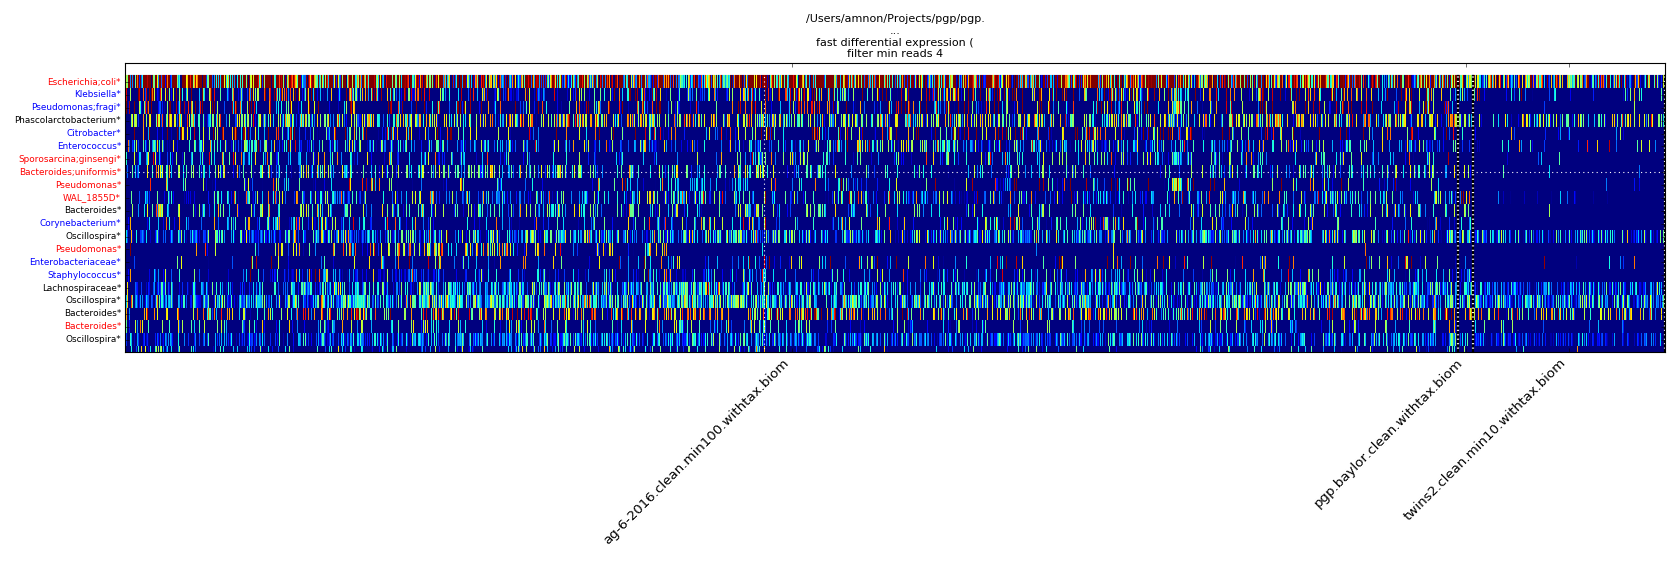

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x2162d8550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x214dca860>)

In [63]:
hs.plotexp(dd,'origexp')

In [65]:
# calculate the american gut fold change compared to the other studies
agfc={}
agpos=hs.findsamples(fec,'origexp','ag-6-2016.clean.min100.withtax.biom')
otherpos=hs.findsamples(fec,'origexp','ag-6-2016.clean.min100.withtax.biom',exclude=True)
agmean=np.mean(fec.data[:,agpos],1)
othermean=np.mean(fec.data[:,otherpos],1)
minval=0.1
agmean[agmean<minval]=minval
othermean[othermean<minval]=minval
agrat=agmean/othermean
for idx,cseq in enumerate(fec.seqs):
        agfc[cseq]=agrat[idx]

In [66]:
# we want only intersting bacteria (have high enough mean in AG)
tfec=hs.filtermean(fec,0.0001)


('612 Bacteria left',)


In [132]:
bloomseqs,bloomnames=hs.readfastaseqs('/Users/amnon/Projects/bloom-filtering/data/oldbloom.fasta')

<IPython.core.display.Javascript object>


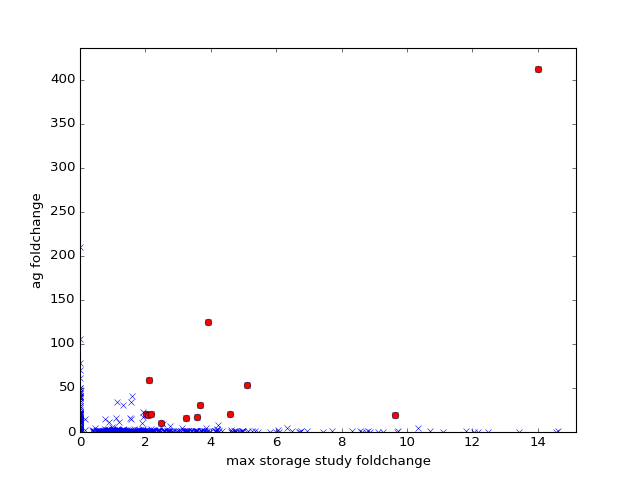

**(NOTBLOOM) Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
agfc-124.389303, maxfc-3.915550, mayo1fc-3.247461, mayo4fc-3.915550, sejin7fc--1.000000, sejin14fc-1.224544, sejin28fc--1.000000
**(NOTBLOOM) Bacteria;Firmicutes;Bacilli;Bacillales;Planococcaceae;Sporosarcina;ginsengi;
agfc-30.218765, maxfc-3.670990, mayo1fc--1.000000, mayo4fc-3.670990, sejin7fc--1.000000, sejin14fc--1.000000, sejin28fc--1.000000
**(NOTBLOOM) Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Yersinia;;
agfc-20.793895, maxfc-2.026496, mayo1fc--1.000000, mayo4fc--1.000000, sejin7fc-1.550874, sejin14fc--1.000000, sejin28fc-2.026496
**(NOTBLOOM) Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Trabulsiella;farmeri;
agfc-170.909747, maxfc-221.818511, mayo1fc-39.913771, mayo4fc-221.818511, sejin7fc-2.186304, sejin14fc--1.000000, sejin28fc-1.207627
**(NOTBLOOM) Bacteria;Proteobacteria;Gammaproteobacteria;Enterob

In [134]:
plt.figure()
bloomseqs=[]
for idx,cseq in enumerate(tfec.seqs):
    if cseq in agfc:
        cagfc=agfc[cseq]
    else:
        cagfc=-1

    maxfc=0
    if cseq in mayo4fc:
        cm4fc=mayo4fc[cseq]
        maxfc=max(maxfc,cm4fc)
    else:
        cm4fc=-1
    if cseq in mayo1fc:
        cm1fc=mayo1fc[cseq]
        maxfc=max(maxfc,cm1fc)
    else:
        cm1fc=-1
    if cseq[:124] in sj7fc:
        csj7fc=sj7fc[cseq[:124]]
        maxfc=max(maxfc,csj7fc)
    else:
        csj7fc=-1
    if cseq[:124] in sj14fc:
        csj14fc=sj14fc[cseq[:124]]
        maxfc=max(maxfc,csj14fc)
    else:
        csj14fc=-1
    if cseq[:124] in sj28fc:
        csj28fc=sj28fc[cseq[:124]]
        maxfc=max(maxfc,csj28fc)
    else:
        csj28fc=-1
    if cseq in bloomseqs:
        plt.plot(maxfc,cagfc,'xr')
    else:
        plt.plot(maxfc,cagfc,'xb')
    if (maxfc>2 and cagfc>10) or (maxfc>50):
        if cseq in bloomseqs:
            print('(BLOOM) '+tfec.tax[idx])
        else:
            print('**(NOTBLOOM) '+tfec.tax[idx])
        print('agfc-%f, maxfc-%f, mayo1fc-%f, mayo4fc-%f, sejin7fc-%f, sejin14fc-%f, sejin28fc-%f' % (cagfc, maxfc, cm1fc,cm4fc,csj7fc,csj14fc,csj28fc))
        bloomseqs.append(cseq)
        plt.plot(maxfc,cagfc,'or')
plt.xlabel('max storage study foldchange')
plt.ylabel('ag foldchange')

In [135]:
tt=hs.filterseqs(fec,bloomseqs)

('25 Bacteria left',)


<IPython.core.display.Javascript object>


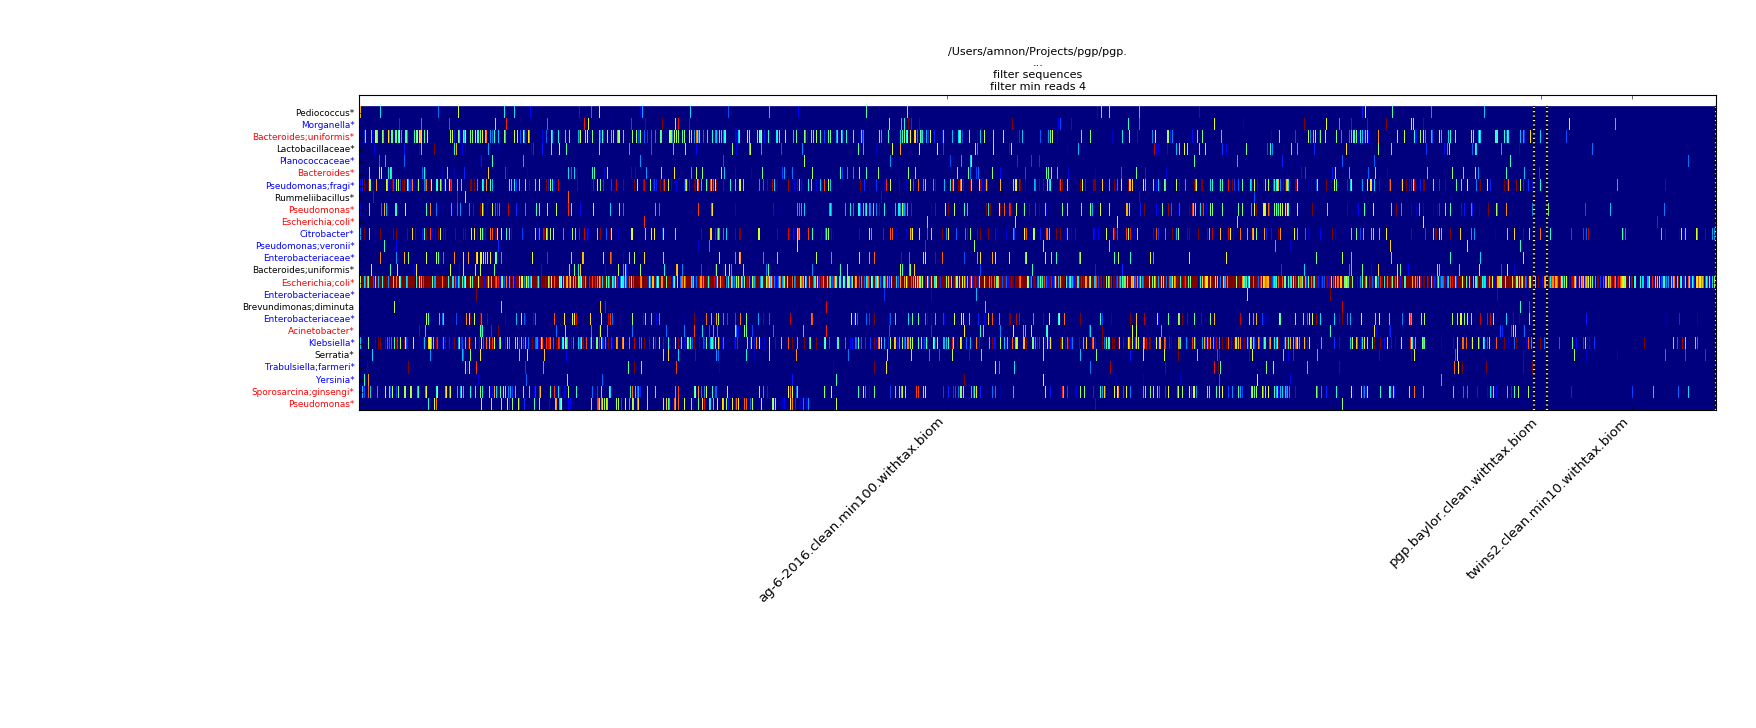

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x15aa1d080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25ad46e48>)

In [136]:
hs.plotexp(tt,'origexp')

In [137]:
tt=hs.filterseqs(mayof,bloomseqs)

('sequence not in experiment', 'TACGAAGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGATCGTTAAGTCAGAGGTGAAATCCCGGAGCTCAACTTCGGAACTGCCTTTGATACTGGCGATCTTGAGTGTGAGAGAGGTATGTGGAACTCCGAG')
('sequence not in experiment', 'TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTTAACCGTGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAAAGTGGAATTCCAAG')
('sequence not in experiment', 'TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATCGGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATG')
('sequence not in experiment', 'TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATG')


('20 Bacteria left',)


<IPython.core.display.Javascript object>


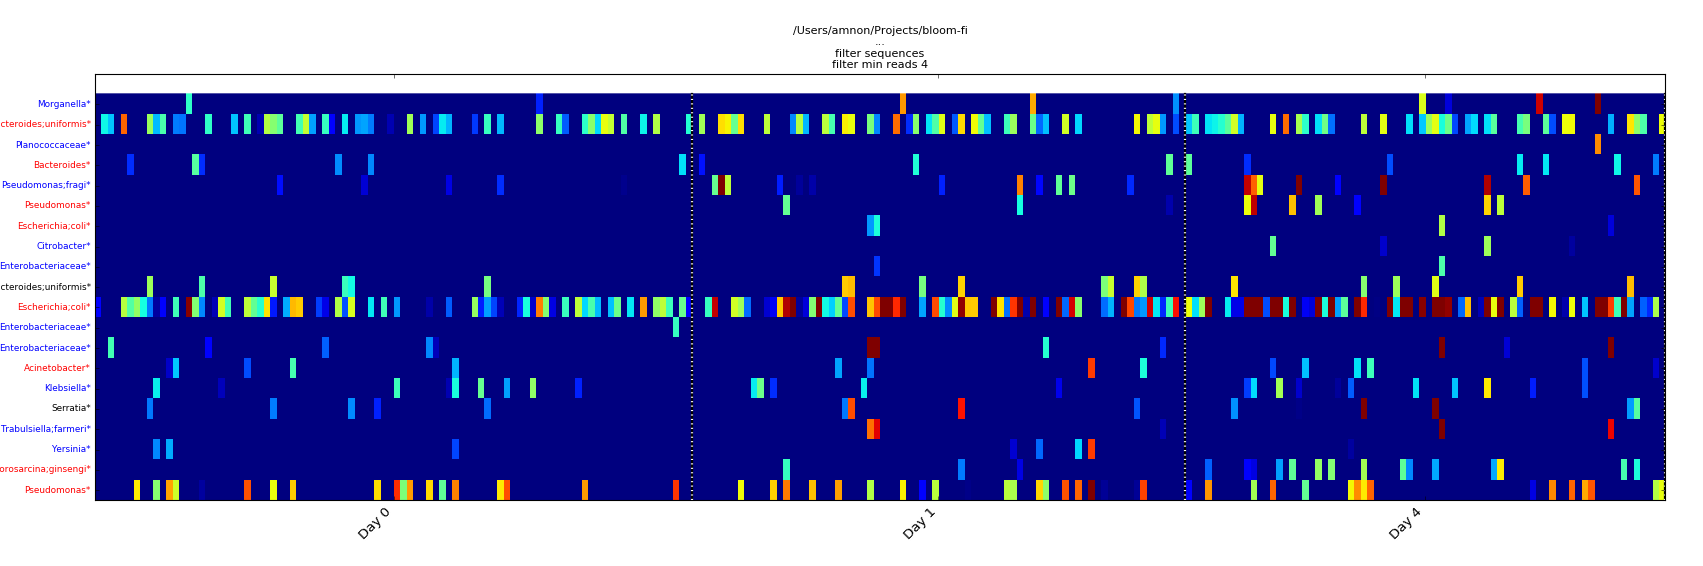

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x123fde6a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x264769f98>)

In [138]:
hs.plotexp(tt,'SAMPLE_VISIT')

In [139]:
shortbloom=[]
for cseq in bloomseqs:
    shortbloom.append(cseq[:124])
tt=hs.filterseqs(sjf,shortbloom)

('sequence not in experiment', 'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGATTAAGTCAGATGTGAAATCCCCGAGCTTAACTTGGGAACTGCATTTGAAACTGGTCAGCTAGAGT')
('sequence not in experiment', 'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGATTGAGTCAGATGTGAAATCCCCGGGCTTAACCCGGGAATTGCATCTGATACTGGTCAGCTAGAGT')


('20 Bacteria left',)


<IPython.core.display.Javascript object>


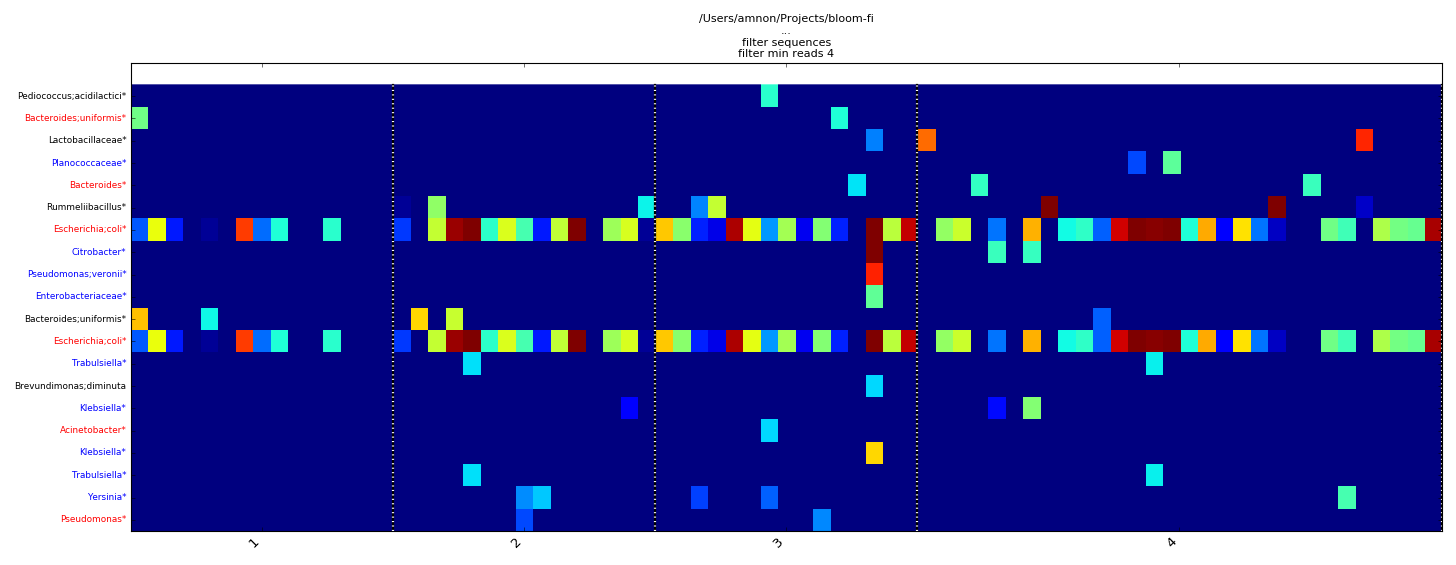

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x148a205c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2933a2ba8>)

In [140]:
hs.plotexp(tt,'time_numeric')